**Author**: *Konstantinos Nikiforidis* (knikif@csd.auth.gr)  
**AEM**: *171*  
**Find and run the notebook online**: *https://colab.research.google.com/drive/1vbuXxYwjP2udVs6WC02YB_H6iqKUU_C_?usp=sharing*  
**GitHub**: *https://github.com/nikifori/Rock-Scissors-Paper-ML-CSD-2023*

# Final Project - Rock-Scissors-Paper Agent
Στόχος του project είναι η κατασκευή ενός ευφυούς πράκτορα που θα μάθει να παίζει το παιχνίδι Rock-
Scissor-paper. Ποιο συγκεκριμένα, ο πράκτορας θα βλέπει μία εικόνα που αντιστοιχεί σε 0: Πέτρα (Rock),

1: Ψαλίδι (Scissor) ή 2: Χαρτί (Paper) και θα επιλέγει το αντίστοιχο σύμβολο που το κερδίζει.  
  
Για την εκπαίδευση του πράκτορα σας, μπορείτε να χρησιμοποιήσετε το παρακάτω σύνολο δεδομένων:
https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors
το οποίο περιέχει 700+ εικόνες για κάθε κίνηση

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torchvision import datasets
from transformers import ViTForImageClassification, ViTImageProcessor
from torch.utils.data import DataLoader
from torchvision import transforms
import os
import pickle
import zipfile
import requests
from io import BytesIO
from pathlib import Path
from PIL import Image
import shutil
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from torch.utils.data import ConcatDataset
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Initiate the constants that are needed for the rest of the colab

In [ ]:
# CONSTANTS
RANDOM_STATE = 0
CLASS_LABELS = {'paper': 0, 'rock': 1, 'scissors': 2}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Download archive dataset from google drive share link and unzipped it locally in the virtual machine of Google Colab

In [ ]:
# specify share link
url='https://www.dropbox.com/scl/fi/1qyfz4whyqxpkvarnbk3e/rock_scissor_paper.zip?rlkey=cfko2e3rf5eb46v149dlsl6k5&dl=1'

def download_and_unzip(url, extract_to = '.'):
    print('Downloading...')
    response = requests.get(url)
    with zipfile.ZipFile(BytesIO(response.content)) as thezip:
        print('Unzipping...')
        thezip.extractall(path=extract_to)
    print('Downloading and Unzipping have finished...')
    print(os.listdir('.'))

# Invoke the function
download_and_unzip(url)

Downloading...
Unzipping...
['.config', 'scissors', 'paper', 'rock', 'rps-cv-images', 'README_rpc-cv-images.txt', 'sample_data']


# Print the number of images per folder and then print one instance from each folder

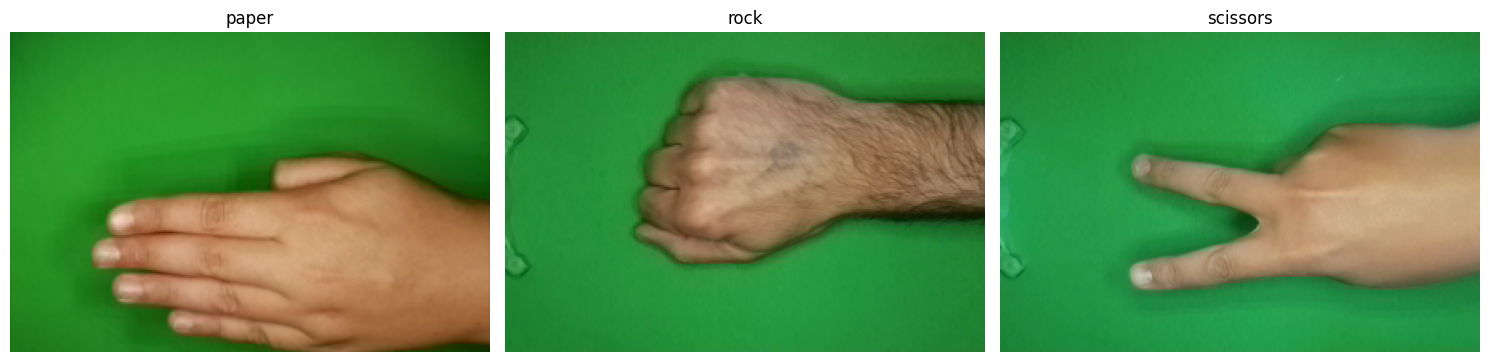

[INFO] Number of instances per class...


{'paper': 712, 'rock': 726, 'scissors': 750}

In [ ]:
# Check the downloaded folders
base_path = Path('/content')

# specify folders
folders = ['paper', 'rock', 'scissors']

# Dictionary to store the number of files in each folder
folder_file_counts = {}
first_images = []

# Using pathlib to count files (non-recursively) in each folder
for folder in folders:
    folder_path = base_path / folder
    # Check if the folder exists
    if folder_path.is_dir():
        # List non-recursive files
        files = [f for f in folder_path.iterdir() if f.is_file()]
        folder_file_counts[folder] = len(files)
        if files:
            first_images.append(files[0])
    else:
        folder_file_counts[folder] = 'Folder does not exist'

# Plotting the first image from each folder
fig, axes = plt.subplots(1, len(first_images), figsize=(15, 5))
for ax, img_path in zip(axes, first_images):
    img = Image.open(str(img_path))
    # print(img.size)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(img_path.parent.name)

plt.tight_layout()
plt.show()

print('[INFO] Number of instances per class...')
folder_file_counts

# Find cardinality of train, test and validation sets

In [ ]:
train_percentage = 0.7
test_percentage = 0.2
val_percentage = 0.1

samples_num_result = {}

for class_name, samples_num in folder_file_counts.items():
    temp_list = [x for x in range(samples_num)]
    train_samples, temp_test_samples = train_test_split(temp_list, test_size=test_percentage+val_percentage, random_state=RANDOM_STATE)
    test_samples, val_samples = train_test_split(temp_test_samples, test_size=0.33, random_state=RANDOM_STATE)
    samples_num_result[class_name] = [len(train_samples), len(test_samples), len(val_samples)]

for class_name, split in samples_num_result.items():
    print(f'[INFO] Sum of {class_name} is: {sum(split)}')
    print('='*30)

print('[INFO] splits per class are:')
samples_num_result

[INFO] Sum of paper is: 712
[INFO] Sum of rock is: 726
[INFO] Sum of scissors is: 750
[INFO] splits per class are:


{'paper': [498, 143, 71], 'rock': [508, 146, 72], 'scissors': [524, 151, 75]}

In [ ]:
# train_percentage = 0.8
# val_percentage = 0.2

# samples_num_result = {}

# for class_name, samples_num in folder_file_counts.items():
#     temp_list = [x for x in range(samples_num)]
#     train_samples, val_samples = train_test_split(temp_list, test_size=val_percentage, random_state=RANDOM_STATE)
#     samples_num_result[class_name] = [len(train_samples), len(val_samples)]

# for class_name, split in samples_num_result.items():
#     print(f'[INFO] Sum of {class_name} is: {sum(split)}')
#     print('='*30)

# print('[INFO] splits per class are:')
# samples_num_result

# Create a workspace structure such as this:
```text
├── train  
│   ├── class1  
|      ├── 1.jpg  
│      ├── 2.jpg  
│   ├── class2  
|      ├── 1.jpg  
│      ├── 2.jpg  
├── test  
│   ├── class1  
|      ├── 1.jpg  
│      ├── 2.jpg   
│   ├── class2  
|      ├── 1.jpg  
│      ├── 2.jpg
├── valid  
│   ├── class1  
|      ├── 1.jpg  
│      ├── 2.jpg   
│   ├── class2  
|      ├── 1.jpg  
│      ├── 2.jpg  
```

# Here in line 14 we use sorted() for reproducability purposes.
# Each time this code is called the result will be the same

In [ ]:
# Your dictionary with train and validation counts
original_path = Path('./')

# Create the new directory structure
for cls in samples_num_result.keys():
    (original_path / 'train' / cls).mkdir(parents=True, exist_ok=True)
    (original_path / 'test' / cls).mkdir(parents=True, exist_ok=True)
    (original_path / 'valid' / cls).mkdir(parents=True, exist_ok=True)

# Move the files according to the counts in the dictionary
for cls, (train_count, test_count, valid_count) in samples_num_result.items():
    # List all files in the original class directory
    # Sort to ensure reproducability
    files = sorted(list((original_path / cls).glob('*')))

    # Move the specified number of files to train and valid directories
    for i, file in enumerate(files):
        if i < train_count:
            shutil.move(str(file), str(original_path / 'train' / cls / file.name))
        elif i < train_count + test_count:
            shutil.move(str(file), str(original_path / 'test' / cls / file.name))
        elif i < train_count + test_count + valid_count:
            shutil.move(str(file), str(original_path / 'valid' / cls / file.name))


# Create Baseline models using conventional Machine Learning apporaches

In [ ]:
class AddGaussianNoise:
    def __init__(self, mean=0., std_propotion=0.05):
        self.mean = mean
        self.std_propotion = std_propotion

    def __call__(self, tensor):
        max_val = 255 if torch.max(tensor) > 1 else 1
        return tensor + (torch.randn(tensor.size()) * (self.std_propotion * max_val) + self.mean)

In [ ]:
# Define baseline simple transform
simple_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),    # --> grey scale
    transforms.Resize(50), # smaller dimension of the image will match those amound of pixels
    transforms.ToTensor()   # pixel values 0-1
])

In [ ]:
# Define the augmentation transforms
p1 = 1
p2 = 0.5

simple_vertical_mainly_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(50),
    transforms.ToTensor(),
    transforms.RandomVerticalFlip(p=p1),
    transforms.RandomHorizontalFlip(p=p2),
    AddGaussianNoise(mean=0, std_propotion=0.05)])

In [ ]:
# Define the augmentation transforms
p1 = 0.5
p2 = 1

simple_horizontal_mainly_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(50),
    transforms.ToTensor(),
    transforms.RandomVerticalFlip(p=p1),
    transforms.RandomHorizontalFlip(p=p2),
    AddGaussianNoise(mean=0, std_propotion=0.05)])

In [ ]:
# Datasets Initialization
# Load the datasets
train_dataset = datasets.ImageFolder(original_path / 'train', transform=simple_transform)
train_vertical_dataset = datasets.ImageFolder(original_path / 'train', transform=simple_vertical_mainly_transform)
train_horizontal_dataset = datasets.ImageFolder(original_path / 'train', transform=simple_horizontal_mainly_transform)

valid_dataset = datasets.ImageFolder(original_path / 'valid', transform=simple_transform)
valid_vertical_dataset = datasets.ImageFolder(original_path / 'valid', transform=simple_vertical_mainly_transform)
valid_horizontal_dataset = datasets.ImageFolder(original_path / 'valid', transform=simple_horizontal_mainly_transform)

# Concat the datasets
train_combined_dataset = ConcatDataset([train_dataset, train_vertical_dataset, train_horizontal_dataset])
valid_combined_dataset = ConcatDataset([valid_dataset, valid_vertical_dataset, valid_horizontal_dataset])

In [ ]:
simple_train_x = []
simple_train_y = []

for image, label in tqdm(train_combined_dataset):
    # Flatten the image tensor and convert to numpy array
    simple_train_x.append(image.view(-1).numpy())
    simple_train_y.append(label)

# Convert lists to numpy arrays
simple_train_x = np.array(simple_train_x)
simple_train_y = np.array(simple_train_y)

simple_train_x.shape, simple_train_y.shape

100%|██████████| 5247/5247 [00:19<00:00, 268.63it/s]


((5247, 3750), (5247,))

In [ ]:
simple_valid_x = []
simple_valid_y = []

for image, label in tqdm(valid_combined_dataset):
    # Flatten the image tensor and convert to numpy array
    simple_valid_x.append(image.view(-1).numpy())
    simple_valid_y.append(label)

# Convert lists to numpy arrays
simple_valid_x = np.array(simple_valid_x)
simple_valid_y = np.array(simple_valid_y)

simple_valid_x.shape, simple_valid_y.shape

100%|██████████| 1317/1317 [00:03<00:00, 409.85it/s]


((1317, 3750), (1317,))

In [ ]:
# Initialize the models
svc = SVC()
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
knn = KNeighborsClassifier(weights='distance', n_jobs=-1)

# Train the models
svc.fit(simple_train_x, simple_train_y)
rf.fit(simple_train_x, simple_train_y)
knn.fit(simple_train_x, simple_train_y)

# Validate the models
svc_predictions = svc.predict(simple_valid_x)
rf_predictions = rf.predict(simple_valid_x)
knn_predictions = knn.predict(simple_valid_x)

svc_accuracy = accuracy_score(simple_valid_y, svc_predictions)
rf_accuracy = accuracy_score(simple_valid_y, rf_predictions)
knn_accuracy = accuracy_score(simple_valid_y, knn_predictions)

print(f"SVC Accuracy: {svc_accuracy}")
print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"KNN Accuracy: {knn_accuracy}")

SVC Accuracy: 0.9081245254365984
Random Forest Accuracy: 0.911921032649962
KNN Accuracy: 0.8815489749430524


In [ ]:
# create a function to compare results and return the reward
# random_agent_gesture and my_gesture are in [0, 1, 2]
def reward_func(random_agent_gesture: int,
                my_gesture: int) -> int:

    # Rules:
    # Paper (0) beats Rock (1)
    # Rock (1) beats Scissors (2)
    # Scissors (2) beats Paper (0)

    if random_agent_gesture == my_gesture:
        # It's a draw
        return 0
    elif (random_agent_gesture == 0 and my_gesture == 1) or \
         (random_agent_gesture == 1 and my_gesture == 2) or \
         (random_agent_gesture == 2 and my_gesture == 0):
        # my_gesture loses
        return -1
    else:
        # my_gesture wins
        return 1

def choose_action(predicted_label: int) -> int:
    if predicted_label == 0:    # if paper --> scissors
        return 2
    elif predicted_label == 1:  # if rock --> paper
        return 0
    else:
        return 1              # if scissors --> rock

In [ ]:
# Define Random Agent's transformations
# Define the sequential transforms
p1 = 0.5
p2 = 0.5

game_loop_transform = transforms.Compose([
    # casual preprocess
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(50),
    transforms.ToTensor(),

    # random agent's transformations
    transforms.RandomVerticalFlip(p=p1),
    transforms.RandomHorizontalFlip(p=p2),
    AddGaussianNoise(mean=0, std_propotion=0.05)])

In [ ]:
# Load the datasets
test_dataset = datasets.ImageFolder(original_path / 'test', transform=game_loop_transform)

In [ ]:
def play_the_game(ml_model, dataset, N):
    cumulative_rewards = []
    total_reward = 0
    for turn_num in tqdm(range(N)):
        # Randomly select an image and its label from the dataset
        idx = random.randint(0, len(dataset) - 1)
        image, true_label = dataset[idx]

        # Preprocess and prepare the image tensor for the model
        image_flat = image.view(-1).numpy()  # Flatten the image for sklearn models

        # Perform inference
        predicted_label = int(ml_model.predict([image_flat])[0])  # Predict the label

        # Calculate and append the reward
        total_reward += reward_func(true_label, choose_action(predicted_label))
        cumulative_rewards.append(total_reward)

        # Print current cumulative reward
        # print(f"[INFO] Turn {turn_num + 1}: Current cumulative reward is: {sum(rewards)}")

    print(f"Maximum cumulative reward is: {N}")
    print(f"Final cumulative reward is: {total_reward}")
    return cumulative_rewards

100%|██████████| 1000/1000 [00:17<00:00, 56.09it/s]


Maximum cumulative reward is: 1000
Final cumulative reward is: 893


100%|██████████| 1000/1000 [00:27<00:00, 36.08it/s]


Maximum cumulative reward is: 1000
Final cumulative reward is: 895


100%|██████████| 1000/1000 [00:50<00:00, 19.87it/s]


Maximum cumulative reward is: 1000
Final cumulative reward is: 880


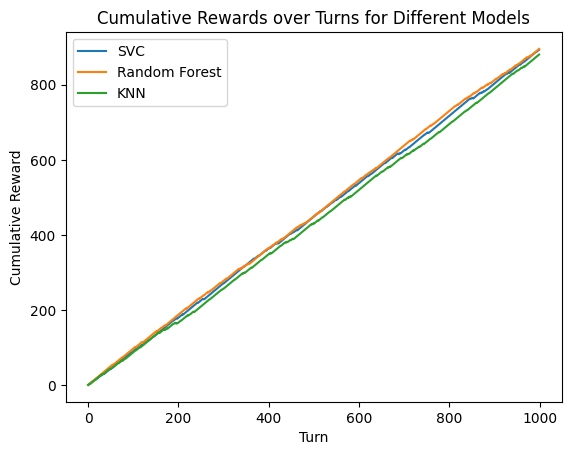

In [ ]:
models = [svc, rf, knn]
model_names = ["SVC", "Random Forest", "KNN"]
rewards_per_model = {}

for model, name in zip(models, model_names):
    rewards = play_the_game(model, test_dataset, 1000)
    rewards_per_model[name] = rewards

# Plotting
for name, rewards in rewards_per_model.items():
    plt.plot(rewards, label=name)

plt.xlabel("Turn")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Rewards over Turns for Different Models")
plt.legend()
plt.show()

# Load ViT transformer from here: https://huggingface.co/google/vit-base-patch16-224  

# Use ViT and on top of it a dense NN so as to set it trainable and use the combined model to classify the images

In [ ]:
class CustomViTClassifier(nn.Module):
    def __init__(self, num_classes, vit_model_name='google/vit-base-patch16-224'):
        super(CustomViTClassifier, self).__init__()
        # Load the pretrained ViT model
        self.vit = ViTForImageClassification.from_pretrained(vit_model_name)

        # Replace the classifier head of ViT with custom layers
        self.classifier = nn.Sequential(
            nn.Linear(self.vit.classifier.out_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

        # Set self.training = False so as to use softmax only at inference mode
        self.training = False

        # Freeze all the parameters in the ViT model except for the classifier layer
        for name, param in self.named_parameters():
            if 'classifier' not in name:  # Freeze parameters not in the classifier layer
                param.requires_grad = False

        # Calculate and print the number of trainable and non-trainable parameters
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        non_trainable_params = total_params - trainable_params
        print(f"Total parameters: {total_params:_}")
        print(f"Trainable parameters: {trainable_params:_}")
        print(f"Non-trainable parameters: {non_trainable_params:_}")


    def forward(self, x):
        # Forward pass through ViT base
        x = self.vit(x).logits

        # Forward pass through the custom classifier
        x = self.classifier(x)

        if not self.training:
            x = torch.softmax(x, dim=1)

        return x

# Train Loop

In [ ]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
processor

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
class AddGaussianNoise:
    def __init__(self, mean=0., std_propotion=0.05):
        self.mean = mean
        self.std_propotion = std_propotion

    def __call__(self, tensor):
        # Check if x is a PIL Image and convert it to a Tensor
        if isinstance(tensor, Image.Image):
            transform = transforms.ToTensor()
            tensor = transform(tensor)

        max_val = 255 if torch.max(tensor) > 1 else 1
        return tensor + (torch.randn(tensor.size()) * (self.std_propotion * max_val) + self.mean)

In [ ]:
# Define the augmentation transforms
p1 = 1
p2 = 0.5

vertical_mainly_transform = transforms.Compose([
    transforms.RandomVerticalFlip(p=p1),
    transforms.RandomHorizontalFlip(p=p2),
    AddGaussianNoise(mean=0, std_propotion=0.05)])

In [ ]:
# Define the augmentation transforms
p1 = 0.5
p2 = 1

horizontal_mainly_transform = transforms.Compose([
    transforms.RandomVerticalFlip(p=p1),
    transforms.RandomHorizontalFlip(p=p2),
    AddGaussianNoise(mean=0, std_propotion=0.05)])

In [ ]:
# Define simple and combined ViT transforms
def viTtransform(image):
    return processor(images=image, return_tensors="pt")['pixel_values'].squeeze(0)

def viTtransform_vertical_mainly(image):
    image = processor(images=image, return_tensors="pt")['pixel_values'].squeeze(0)
    image = vertical_mainly_transform(image)
    return image

def viTtransform_horizontal_mainly(image):
    image = processor(images=image, return_tensors="pt")['pixel_values'].squeeze(0)
    image = horizontal_mainly_transform(image)
    return image

In [ ]:
!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00


In [ ]:
# Log in to your W&B account
import wandb
os.environ["WANDB_API_KEY"] = "304019a0d101f873b178718c915f413c44cfbf34"
wandb_project_name = 'rsp-agent'
wandb_entity = 'kwstasrr'

wandb.login()

wandb: Currently logged in as: kwstasrr. Use `wandb login --relogin` to force relogin


True

In [ ]:
wandb.init(project=wandb_project_name, entity=wandb_entity)

In [ ]:
# Load the pretrained ViT model processor
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
num_classes = 3  # paper, rock, scissors
model = CustomViTClassifier(num_classes)

# Load the datasets
train_dataset = datasets.ImageFolder(original_path / 'train', transform=viTtransform)
train_vertical_dataset = datasets.ImageFolder(original_path / 'train', transform=viTtransform_vertical_mainly)
train_horizontal_dataset = datasets.ImageFolder(original_path / 'train', transform=viTtransform_horizontal_mainly)

valid_dataset = datasets.ImageFolder(original_path / 'valid', transform=viTtransform)
valid_vertical_dataset = datasets.ImageFolder(original_path / 'valid', transform=viTtransform_vertical_mainly)
valid_horizontal_dataset = datasets.ImageFolder(original_path / 'valid', transform=viTtransform_horizontal_mainly)

# Concat the datasets
train_combined_dataset = ConcatDataset([train_dataset, train_vertical_dataset, train_horizontal_dataset])
valid_combined_dataset = ConcatDataset([valid_dataset, valid_vertical_dataset, valid_horizontal_dataset])

# Print the mapping of class names to indices for both datasets
print("Class to index mapping for training dataset:")
print(train_dataset.class_to_idx)

print("\nClass to index mapping for validation dataset:")
print(valid_dataset.class_to_idx)

train_combined_loader = DataLoader(train_combined_dataset, batch_size=32, shuffle=True)
valid_combined_loader = DataLoader(valid_combined_dataset, batch_size=32, shuffle=False)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'[INFO] Current device is: {device}')
model.to(device)
num_epochs = 30  # Set the number of epochs

for epoch in range(num_epochs):
    # prepare model for training
    model.train()
    total_loss = 0
    for inputs, labels in tqdm(train_combined_loader):
        # print(labels)
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        # default reduction = 'mean'
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_combined_loader)
    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss}")

    # Validation loop
    model.eval()
    total = 0
    correct = 0
    total_val_loss = 0
    with torch.no_grad():
        for inputs, labels in tqdm(valid_combined_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Compute loss for the current batch
            val_loss = criterion(outputs, labels)
            total_val_loss += val_loss.item()

    # Calculate the average loss over all validation batches
    avg_val_loss = total_val_loss / len(valid_combined_loader)
    print(f"Average Validation Loss: {avg_val_loss}")

    validation_accuracy = correct / total
    print(f"Epoch {epoch+1}, Validation Accuracy: {validation_accuracy}")

    # Save the model
    # torch.save(model.state_dict(), f'./CustomViTClassifier_epoch_{epoch}_val_acc_{validation_accuracy}.pth')
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,},
                f'./CustomViTClassifier_epoch_{epoch}_val_acc_{validation_accuracy}.pt')

    # log metrics to wandb
    wandb.log({"train_loss": avg_train_loss, "val_loss": avg_val_loss, "val_accuracy": validation_accuracy})

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()


Total parameters: 87_081_707
Trainable parameters: 1_283_051
Non-trainable parameters: 85_798_656
Class to index mapping for training dataset:
{'paper': 0, 'rock': 1, 'scissors': 2}

Class to index mapping for validation dataset:
{'paper': 0, 'rock': 1, 'scissors': 2}
[INFO] Current device is: cuda


100%|██████████| 164/164 [01:41<00:00,  1.61it/s]


Epoch 1, Training Loss: 0.12466549182189317


100%|██████████| 42/42 [00:25<00:00,  1.66it/s]


Average Validation Loss: 0.5594956449099949
Epoch 1, Validation Accuracy: 0.9916476841305999


100%|██████████| 164/164 [01:42<00:00,  1.61it/s]


Epoch 2, Training Loss: 0.024381736762046698


100%|██████████| 42/42 [00:25<00:00,  1.64it/s]


Average Validation Loss: 0.5545900918188549
Epoch 2, Validation Accuracy: 0.996962794229309


100%|██████████| 164/164 [01:43<00:00,  1.59it/s]


Epoch 3, Training Loss: 0.042425683243320536


100%|██████████| 42/42 [00:25<00:00,  1.64it/s]


Average Validation Loss: 0.562368414231709
Epoch 3, Validation Accuracy: 0.9878511769172361


100%|██████████| 164/164 [01:42<00:00,  1.59it/s]


Epoch 4, Training Loss: 0.06003629778549524


100%|██████████| 42/42 [00:26<00:00,  1.60it/s]


Average Validation Loss: 0.5541922265575046
Epoch 4, Validation Accuracy: 0.996962794229309


100%|██████████| 164/164 [01:43<00:00,  1.59it/s]


Epoch 5, Training Loss: 0.05116561901505855


100%|██████████| 42/42 [00:25<00:00,  1.62it/s]


Average Validation Loss: 0.5525288596039727
Epoch 5, Validation Accuracy: 0.9992406985573272


100%|██████████| 164/164 [01:42<00:00,  1.59it/s]


Epoch 6, Training Loss: 0.048745205422975085


100%|██████████| 42/42 [00:25<00:00,  1.64it/s]


Average Validation Loss: 0.5541029515720549
Epoch 6, Validation Accuracy: 0.9977220956719818


100%|██████████| 164/164 [01:43<00:00,  1.58it/s]


Epoch 7, Training Loss: 0.10123713536040854


100%|██████████| 42/42 [00:26<00:00,  1.58it/s]


Average Validation Loss: 0.5627248400733584
Epoch 7, Validation Accuracy: 0.9886104783599089


100%|██████████| 164/164 [01:44<00:00,  1.56it/s]


Epoch 8, Training Loss: 0.11435739503465225


100%|██████████| 42/42 [00:26<00:00,  1.59it/s]


Average Validation Loss: 0.5537439088026682
Epoch 8, Validation Accuracy: 0.9977220956719818


100%|██████████| 164/164 [01:44<00:00,  1.56it/s]


Epoch 9, Training Loss: 0.0535699919296549


100%|██████████| 42/42 [00:26<00:00,  1.58it/s]


Average Validation Loss: 0.5547448836621784
Epoch 9, Validation Accuracy: 0.996962794229309


100%|██████████| 164/164 [01:46<00:00,  1.54it/s]


Epoch 10, Training Loss: 0.036691932409413215


100%|██████████| 42/42 [00:26<00:00,  1.59it/s]


Average Validation Loss: 0.5514948765436808
Epoch 10, Validation Accuracy: 1.0


100%|██████████| 164/164 [01:45<00:00,  1.55it/s]


Epoch 11, Training Loss: 0.018949026114782188


100%|██████████| 42/42 [00:26<00:00,  1.59it/s]


Average Validation Loss: 0.5514827001662481
Epoch 11, Validation Accuracy: 1.0


100%|██████████| 164/164 [01:45<00:00,  1.56it/s]


Epoch 12, Training Loss: 0.10013307734671073


100%|██████████| 42/42 [00:26<00:00,  1.60it/s]


Average Validation Loss: 0.5614146178676969
Epoch 12, Validation Accuracy: 0.9901290812452543


100%|██████████| 164/164 [01:45<00:00,  1.56it/s]


Epoch 13, Training Loss: 0.056255937796717316


100%|██████████| 42/42 [00:26<00:00,  1.60it/s]


Average Validation Loss: 0.5523182721365065
Epoch 13, Validation Accuracy: 0.9992406985573272


100%|██████████| 164/164 [01:44<00:00,  1.56it/s]


Epoch 14, Training Loss: 0.09600397542045899


100%|██████████| 42/42 [00:26<00:00,  1.61it/s]


Average Validation Loss: 0.5529768949463254
Epoch 14, Validation Accuracy: 0.9984813971146546


100%|██████████| 164/164 [01:45<00:00,  1.55it/s]


Epoch 15, Training Loss: 0.028894359334582665


100%|██████████| 42/42 [00:26<00:00,  1.60it/s]


Average Validation Loss: 0.5531978422687167
Epoch 15, Validation Accuracy: 0.9977220956719818


100%|██████████| 164/164 [01:45<00:00,  1.56it/s]


Epoch 16, Training Loss: 0.022949580707690286


100%|██████████| 42/42 [00:26<00:00,  1.59it/s]


Average Validation Loss: 0.5529727722917285
Epoch 16, Validation Accuracy: 0.9984813971146546


100%|██████████| 164/164 [01:46<00:00,  1.55it/s]


Epoch 17, Training Loss: 0.04574736149013613


100%|██████████| 42/42 [00:26<00:00,  1.61it/s]


Average Validation Loss: 0.5624976030417851
Epoch 17, Validation Accuracy: 0.9878511769172361


100%|██████████| 164/164 [01:45<00:00,  1.56it/s]


Epoch 18, Training Loss: 0.032147070897401736


100%|██████████| 42/42 [00:26<00:00,  1.61it/s]


Average Validation Loss: 0.5514817819708869
Epoch 18, Validation Accuracy: 1.0


100%|██████████| 164/164 [01:44<00:00,  1.57it/s]


Epoch 19, Training Loss: 0.0006470426807751342


100%|██████████| 42/42 [00:26<00:00,  1.61it/s]


Average Validation Loss: 0.5515665880271367
Epoch 19, Validation Accuracy: 1.0


100%|██████████| 164/164 [01:44<00:00,  1.56it/s]


Epoch 20, Training Loss: 0.033184221517658985


100%|██████████| 42/42 [00:26<00:00,  1.60it/s]


Average Validation Loss: 0.5581724217959813
Epoch 20, Validation Accuracy: 0.9931662870159453


100%|██████████| 164/164 [01:44<00:00,  1.57it/s]


Epoch 21, Training Loss: 0.006188069327020104


100%|██████████| 42/42 [00:26<00:00,  1.58it/s]


Average Validation Loss: 0.5537012503260658
Epoch 21, Validation Accuracy: 0.9977220956719818


100%|██████████| 164/164 [01:44<00:00,  1.57it/s]


Epoch 22, Training Loss: 1.179275678003664e-07


100%|██████████| 42/42 [00:26<00:00,  1.60it/s]


Average Validation Loss: 0.5535154314268202
Epoch 22, Validation Accuracy: 0.9977220956719818


100%|██████████| 164/164 [01:44<00:00,  1.57it/s]


Epoch 23, Training Loss: 0.000825337701270274


100%|██████████| 42/42 [00:26<00:00,  1.60it/s]


Average Validation Loss: 0.5520940352053869
Epoch 23, Validation Accuracy: 0.9992406985573272


100%|██████████| 164/164 [01:44<00:00,  1.56it/s]


Epoch 24, Training Loss: 0.0057789373195343005


100%|██████████| 42/42 [00:26<00:00,  1.60it/s]


Average Validation Loss: 0.5529581961177644
Epoch 24, Validation Accuracy: 0.9984813971146546


100%|██████████| 164/164 [01:45<00:00,  1.56it/s]


Epoch 25, Training Loss: 0.01431421846951505


100%|██████████| 42/42 [00:26<00:00,  1.61it/s]


Average Validation Loss: 0.5535059344200861
Epoch 25, Validation Accuracy: 0.9977220956719818


100%|██████████| 164/164 [01:45<00:00,  1.56it/s]


Epoch 26, Training Loss: 0.02735276269159018


100%|██████████| 42/42 [00:26<00:00,  1.60it/s]


Average Validation Loss: 0.5516101590224675
Epoch 26, Validation Accuracy: 1.0


100%|██████████| 164/164 [01:45<00:00,  1.56it/s]


Epoch 27, Training Loss: 0.1711258005134656


100%|██████████| 42/42 [00:26<00:00,  1.59it/s]


Average Validation Loss: 0.5557705391021002
Epoch 27, Validation Accuracy: 0.9954441913439636


100%|██████████| 164/164 [01:45<00:00,  1.55it/s]


Epoch 28, Training Loss: 0.23023688385282734


100%|██████████| 42/42 [00:26<00:00,  1.57it/s]


Average Validation Loss: 0.5550961707319532
Epoch 28, Validation Accuracy: 0.9962034927866363


100%|██████████| 164/164 [01:45<00:00,  1.55it/s]


Epoch 29, Training Loss: 0.06542277945826638


100%|██████████| 42/42 [00:26<00:00,  1.60it/s]


Average Validation Loss: 0.5535871698742821
Epoch 29, Validation Accuracy: 0.9977220956719818


100%|██████████| 164/164 [01:45<00:00,  1.55it/s]


Epoch 30, Training Loss: 0.0490789805404047


100%|██████████| 42/42 [00:26<00:00,  1.59it/s]


Average Validation Loss: 0.5556764049189431
Epoch 30, Validation Accuracy: 0.9954441913439636


train_loss,▅▂▂▃▃▂▄▄▃▂▂▄▃▄▂▂▂▂▁▂▁▁▁▁▁▂▆█▃▂
val_accuracy,▃▆▁▆█▇▁▇▆██▂█▇▇▇▁██▄▇▇█▇▇█▅▆▇▅
val_loss,▆▃█▃▂▃█▂▃▁▁▇▂▂▂▂█▁▁▅▂▂▁▂▂▁▄▃▂▄
train_loss,0.04908
val_accuracy,0.99544
val_loss,0.55568


In [ ]:
wandb.finish()

In [ ]:
processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

# Loop of the game

# Define the image transformation for the game as it is prompted on step 4 in the assignment (Preprocess Image)

In [ ]:
# Define Random Agent's transformations
# Define the sequential transforms
p1 = 0.5
p2 = 0.5

game_loop_transform_vit = transforms.Compose([
    # random agent's transformations
    transforms.RandomVerticalFlip(p=p1),
    transforms.RandomHorizontalFlip(p=p2),
    AddGaussianNoise(mean=0, std_propotion=0.05)])

# Download fine-tuned model from my drive

In [ ]:
def download_custom_model(link, save_to='.'):
    # Sending a request to the URL
    response = requests.get(link)

    # create file path
    save_to = Path(save_to)
    filepath = save_to / "model.pt"

    # Checking if the request was successful
    if response.status_code == 200:
        # Writing the content to a .pt file
        with open(filepath, "wb") as file:
            file.write(response.content)
        print("Download complete. Model saved as model.pt")
    else:
        print("Failed to download the file. Status code:", response.status_code)

In [ ]:
# download_custom_model("https://drive.google.com/uc?export=download&confirm=no_antivirus&id=107gG6CxVL8OlIj5yGDv0qAcq3H8PNIQo")
download_custom_model("https://www.dropbox.com/scl/fi/ifwoxitny2nnxysxhlsj7/CustomViTClassifier_epoch_17_val_acc_1.0.pt?rlkey=zbryro10qm935jc3gcrrwnqvq&dl=1")

Download complete. Model saved as model.pt


# Load fine-tuned model stemmed from the fine-tuning process earlier

In [ ]:
# Instantiate the model with the number of classes you trained it on
def load_CustomViTClassifier(num_classes: int=3,
                             model_path: str=None):

    num_classes = num_classes  # replace with the actual number of classes you used
    model = CustomViTClassifier(num_classes)

    # Load the saved model weights
    model.load_state_dict(torch.load(f'{model_path}', map_location=torch.device('cpu'))['model_state_dict'])

    # Move the model to an appropriate device, e.g., GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # load processor
    processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

    return model, processor

In [ ]:
model, processor = load_CustomViTClassifier(3, '/content/model.pt')

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Total parameters: 87_081_707
Trainable parameters: 1_283_051
Non-trainable parameters: 85_798_656


In [ ]:
def viTtransform_game_loop(image):
    # Firstly apply model's transforms
    image = processor(images=image, return_tensors="pt")['pixel_values'].squeeze(0)
    # Secondly, apply the transforms that are specified in the assignment PDF
    image = game_loop_transform_vit(image)
    return image

# Re-Initialize datasets and concat them

In [ ]:
# Load the datasets
test_dataset = datasets.ImageFolder(original_path / 'test', transform=viTtransform_game_loop)

# Time to play the game

In [ ]:
# Remember class labels
CLASS_LABELS

{'paper': 0, 'rock': 1, 'scissors': 2}

In [ ]:
# Number of turns
N = 1000

model.eval()
model.to(device)
rewards = []
for turn_num in tqdm(range(N)):
    # Randomly select an image and its label from the whole dataset
    idx = random.randint(0, len(test_dataset) - 1)
    image, true_label = test_dataset[idx]

    # Preprocess and prepare the image tensor for the model
    image = image.unsqueeze(0).to(device)  # Add batch dimension and send to device

    # Perform inference
    with torch.no_grad():
        output = model(image)
        predicted_label = int(torch.argmax(output, dim=1).item())  # Get the index of the max log-probability

    rewards.append(reward_func(true_label, choose_action(predicted_label)))

    # print(f"[INFO] Current cummulative reward is: {sum(rewards)}")

print(f"Maximum cummulative reward is: {N}")
print(f"Final cummulative reward is: {sum(rewards)}")

[INFO] Current cummulative reward is: 1
[INFO] Current cummulative reward is: 2
[INFO] Current cummulative reward is: 3
[INFO] Current cummulative reward is: 4
[INFO] Current cummulative reward is: 5
[INFO] Current cummulative reward is: 6
[INFO] Current cummulative reward is: 7
[INFO] Current cummulative reward is: 8
[INFO] Current cummulative reward is: 9
[INFO] Current cummulative reward is: 10
[INFO] Current cummulative reward is: 11
[INFO] Current cummulative reward is: 12
[INFO] Current cummulative reward is: 13
[INFO] Current cummulative reward is: 14
[INFO] Current cummulative reward is: 15
[INFO] Current cummulative reward is: 16
[INFO] Current cummulative reward is: 17
[INFO] Current cummulative reward is: 18
[INFO] Current cummulative reward is: 19
[INFO] Current cummulative reward is: 20
[INFO] Current cummulative reward is: 21
[INFO] Current cummulative reward is: 22
[INFO] Current cummulative reward is: 23
[INFO] Current cummulative reward is: 24
[INFO] Current cummulativ

# Investigate some pictures that the model predicts wrong

In [ ]:
CLASS_LABELS

{'paper': 0, 'rock': 1, 'scissors': 2}

In [ ]:
# Number of turns
N=20000

model.eval()
model.to(device)
rewards = []
saved_images = []  # List to store images
saved_predictions = []

for turn_num in tqdm(range(N)):
    idx = random.randint(0, len(test_dataset) - 1)
    image, true_label = test_dataset[idx]
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        predicted_label = int(torch.argmax(output, dim=1).item())

    reward = reward_func(true_label, choose_action(predicted_label))
    rewards.append(reward)

    if reward in [0, -1]:
        saved_predictions.append(predicted_label)
        saved_images.append(image.cpu().squeeze(0))  # Save image and remove batch dimension

print(f"Maximum cummulative reward is: {N}")
print(f"Final cummulative reward is: {sum(rewards)}")

100%|██████████| 20000/20000 [07:39<00:00, 43.51it/s]

Maximum cummulative reward is: 20000
Final cummulative reward is: 19968


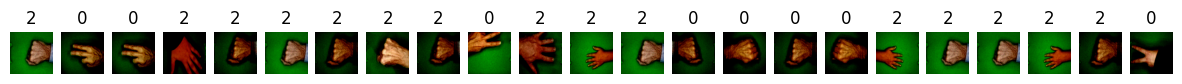

In [ ]:
# Display saved images
fig, axs = plt.subplots(1, len(saved_images), figsize=(15, 15))
for i, img in enumerate(saved_images):
    axs[i].imshow(img.permute(1, 2, 0))  # Permute to change the channel position for display
    axs[i].set_title(f"{saved_predictions[i]}")
    axs[i].axis('off')
plt.show()